In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline

In [2]:
df = pd.read_csv('main_task.csv')

In [3]:
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
              'price_range', 'reviews_number', 'reviews', 'url_ta', 'id_ta']
df.head(5)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   restaurant_id   40000 non-null  object 
 1   city            40000 non-null  object 
 2   cuisine_style   30717 non-null  object 
 3   ranking         40000 non-null  float64
 4   rating          40000 non-null  float64
 5   price_range     26114 non-null  object 
 6   reviews_number  37457 non-null  float64
 7   reviews         40000 non-null  object 
 8   url_ta          40000 non-null  object 
 9   id_ta           40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
df.describe()

,ranking,rating,reviews_number
count,40000.000000,40000.000000,37457.000000
mean,3676.028525,3.993037,124.825480
std,3708.749567,0.668417,295.666352
min,1.000000,1.000000,2.000000
25%,973.000000,3.500000,9.000000
50%,2285.000000,4.000000,33.000000
75%,5260.000000,4.500000,115.000000
max,16444.000000,5.000000,9660.000000


In [6]:
df.nunique()

restaurant_id     11909
city                 31
cuisine_style      9007
ranking           11936
rating                9
price_range           3
reviews_number     1459
reviews           33516
url_ta            39980
id_ta             39980
dtype: int64

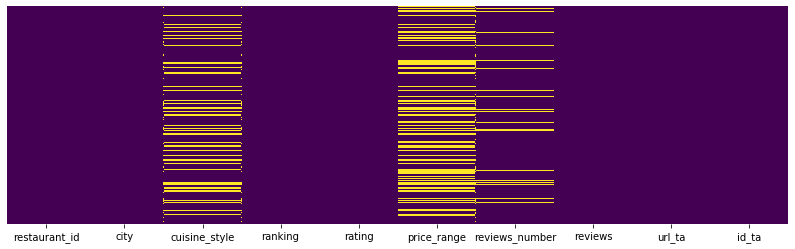

In [7]:
#Анализ пропусков в столбцах
plt.figure(figsize=(14, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap = 'viridis')

In [8]:
def analyse_numeric(datafr, column):
    '''Функция для визуализации распределения.
       Принимает параметром строковое название столбца
       Печатает различные статистические показатели и строит гистограмму'''
    count = datafr[column].count()
    mean = datafr[column].mean()
    std = datafr[column].std()
    median = datafr[column].median()
    perc25 = datafr[column].quantile(0.25)
    perc75 = datafr[column].quantile(0.75)
    IQR = perc75 - perc25
    range_min = datafr[column].min()
    range_max = datafr[column].max()
    margin = (range_max - range_min)/10
    range_start = range_min - margin
    range_stop = range_max + margin
    range_ = (range_start, range_stop)
    outliers = datafr[column].loc[(datafr[column] < perc25 - 1.5*IQR) | (datafr[column] > perc75 + 1.5*IQR)]

    print('Количество: {}, Среднее: {:.3f}, Стандартное отклонение: {:.3f}.'.format(count, mean, std))
    print('Минимум: {}, 25-й перцентиль: {}, Медиана: {}, 75-й перцентиль: {}, Максимум: {}, IQR: {}.'
          .format(range_min, perc25, median, perc75, range_max, IQR))
    print('Количество пропусков в столбце: ', pd.isnull(datafr[column]).sum())
    print('Границы выбросов: [{f}, {l}].'.format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
          , 'Количество выбросов: ', len(outliers))

    datafr[column].loc[datafr[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                  .hist(bins = 30, range = range_, label = 'В границах выбросов')
    outliers.hist(bins = 30, range = range_, label = 'Выбросы')
    
    plt.legend()

## Первичный осмотр данных

### restaurant_id

In [9]:
df.restaurant_id.nunique()

11909

### city

In [10]:
df.city.value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

### cuisine_style

In [11]:
df.cuisine_style.value_counts()

['Italian']                                                            1032
['French']                                                              805
['Spanish']                                                             695
['French', 'European']                                                  405
['Cafe']                                                                403
                                                                       ... 
['Bar', 'Fast Food', 'Mediterranean', 'European', 'Spanish', 'Pub']       1
['Bar', 'European', 'American', 'Vegetarian Friendly']                    1
['Indian', 'International', 'Vegetarian Friendly']                        1
['Bar', 'European', 'Pub', 'Swedish']                                     1
['French', 'Brew Pub']                                                    1
Name: cuisine_style, Length: 9007, dtype: int64

### ranking

Количество: 40000, Среднее: 3676.029, Стандартное отклонение: 3708.750.
Минимум: 1.0, 25-й перцентиль: 973.0, Медиана: 2285.0, 75-й перцентиль: 5260.0, Максимум: 16444.0, IQR: 4287.0.
Количество пропусков в столбце:  0
Границы выбросов: [-5457.5, 11690.5]. Количество выбросов:  2450


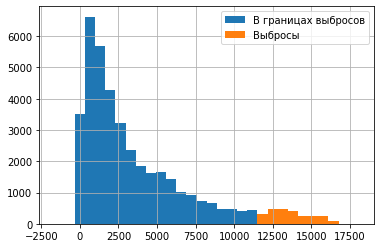

In [12]:
analyse_numeric(df, 'ranking')

### rating

Количество: 40000, Среднее: 3.993, Стандартное отклонение: 0.668.
Минимум: 1.0, 25-й перцентиль: 3.5, Медиана: 4.0, 75-й перцентиль: 4.5, Максимум: 5.0, IQR: 1.0.
Количество пропусков в столбце:  0
Границы выбросов: [2.0, 6.0]. Количество выбросов:  340


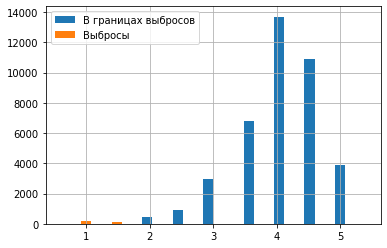

In [13]:
analyse_numeric(df, 'rating')

### price_range

In [14]:
df.price_range.value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

### reviews_number

Количество: 37457, Среднее: 124.825, Стандартное отклонение: 295.666.
Минимум: 2.0, 25-й перцентиль: 9.0, Медиана: 33.0, 75-й перцентиль: 115.0, Максимум: 9660.0, IQR: 106.0.
Количество пропусков в столбце:  2543
Границы выбросов: [-150.0, 274.0]. Количество выбросов:  4348


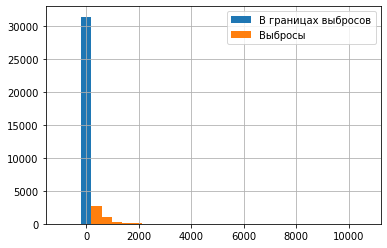

In [15]:
analyse_numeric(df, 'reviews_number')

In [16]:
len(df[df.reviews_number >= 2000])

140

### reviews

In [17]:
#pd.DataFrame(df.reviews.value_counts())
df.reviews.value_counts()

[[], []]                                                                                                                              6471
[['Whenever in Madrid, we never miss this gem...', 'Underrated sushi restaurant with very good...'], ['04/11/2017', '12/02/2016']]       2
[['Very good all around', 'Our first Madrid restaurant'], ['11/20/2017', '10/11/2017']]                                                  2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                                                         2
[['ok for beer, not for dinner'], ['12/20/2017']]                                                                                        2
                                                                                                                                      ... 
[['The green curry is far too sweet.....', 'Consistently Good Food'], ['06/30/2017', '11/27/2016']]                                      1
[['So much choice', 'Then h

In [18]:
#df['reviews_dates'] = df['reviews'].str.findall('\d+/\d+/\d+')
#df[['reviews', 'reviews_dates']].head()

### url_ta

In [19]:
df.url_ta.value_counts()

/Restaurant_Review-g187514-d13002276-Reviews-Delish_Vegan_Doughnuts-Madrid.html        2
/Restaurant_Review-g187514-d1315077-Reviews-El_Pimiento_Verde-Madrid.html              2
/Restaurant_Review-g187514-d7809594-Reviews-La_Guapa-Madrid.html                       2
/Restaurant_Review-g187514-d2477531-Reviews-Haya_19-Madrid.html                        2
/Restaurant_Review-g187514-d7337366-Reviews-Lady_Madonna-Madrid.html                   2
                                                                                      ..
/Restaurant_Review-g187791-d1034652-Reviews-Ristorante_La_Barchetta-Rome_Lazio.html    1
/Restaurant_Review-g187147-d695083-Reviews-Apollon-Paris_Ile_de_France.html            1
/Restaurant_Review-g274707-d4733480-Reviews-Mystic_Pizzerie-Prague_Bohemia.html        1
/Restaurant_Review-g186338-d10487860-Reviews-Enjoy_Lasagna-London_England.html         1
/Restaurant_Review-g274707-d9875572-Reviews-Super_Tramp_Coffee-Prague_Bohemia.html     1
Name: url_ta, Length:

### id_ta

In [20]:
df.id_ta.value_counts()

d13002276    2
d2477531     2
d8753348     2
d3685055     2
d7809594     2
            ..
d3707424     1
d2471551     1
d10005052    1
d10673026    1
d10479109    1
Name: id_ta, Length: 39980, dtype: int64

## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [44]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['restaurant_id', 'rating'], axis = 1)
y = df['rating']

In [46]:
# В первом приближении попробуем удалить данные типа object, и заполним пропущенные значения медианой
X = df.drop(['restaurant_id', 'rating', 'city', 'cuisine_style', 'price_range', 'reviews', 'url_ta', 'id_ta'], axis = 1)
X.head()

,ranking,reviews_number
0,5570.0,194.0
1,1537.0,10.0
2,353.0,688.0
3,3458.0,3.0
4,621.0,84.0


In [47]:
#X.reviews_number.fillna(value=df.reviews_number.median(), inplace=True)
X.reviews_number.fillna(value=df.reviews_number.mean(), inplace=True)

,reviews_number
count,40000.000000
mean,124.825480
std,286.113292
min,2.000000
25%,10.000000
50%,38.000000
75%,124.825480
max,9660.000000


In [48]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Создание, обучение и тестирование модели

In [49]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [50]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.42981065600649354
